<a href="https://colab.research.google.com/github/lee-53/ECE-4380-F25/blob/main/Clean_Classification_and_performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification and Performance

Make sure you are connected to a T4 GPU runtime. The following code should report true if you are.

In [1]:
import torchvision
print(torchvision.__version__)


import torch
print("GPU available =", torch.cuda.is_available())

0.23.0+cu126
GPU available = True


Install prerequisites needed for this assignment, `thop` is used for profiling PyTorch models https://github.com/ultralytics/thop, while `tqdm` makes your loops show a progress bar https://tqdm.github.io/

In [2]:
!pip install thop segmentation-models-pytorch transformers
import math
import numpy as np
import torch
import torch.nn as nn
import gc
import torchvision
from torchvision import datasets, transforms
from PIL import Image
import segmentation_models_pytorch as smp
import thop
from transformers import ViTFeatureExtractor, ViTForImageClassification
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

# we won't be doing any training here, so let's disable autograd
torch.set_grad_enabled(False)

torch.autograd.grad_mode.set_grad_enabled(mode=False)

## Image Classification

You will be looking at image classification in the first part of this assignment, the goal of image classification is to identify subjects within a given image. In the previous assignment, you looked at using MNIST, which is also a classification task "which number is present", where for images the gold standard is Imagent "which class is present".

You can find out more information about Imagenet here:

https://en.wikipedia.org/wiki/ImageNet


Normally you would want to test classification on ImageNet as that's the dataset in which classification models tend to be trained on. However, the Imagenet dataset is not publicly available nor is it reasonable in size to download via Colab (100s of GBs).

Instead, you will use the Caltech101 dataset. However, Caltech101 uses 101 labels which do not correspond to the Imagenet labels. As such, you will need to also download a bigger classification model to serve as a baseline for accuracy comparisons.

More info can be found about the Caltech101 dataset here:

https://en.wikipedia.org/wiki/Caltech_101

Download the dataset you will be using: Caltech101

In [3]:
# convert to RGB class - some of the Caltech101 images are grayscale and do not match the tensor shapes
class ConvertToRGB:
    def __call__(self, image):
        # If grayscale image, convert to RGB
        if image.mode == "L":
            image = Image.merge("RGB", (image, image, image))
        return image

# Define transformations
transform = transforms.Compose([
    ConvertToRGB(), # first convert to RGB
    transforms.Resize((224, 224)),  # Most pretrained models expect 224x224 inputs
    transforms.ToTensor(),
    # this normalization is shared among all of the torch-hub models we will be using
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Download the dataset

#!rm -rf ./data/caltech101/

!wget -q "https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip" -O caltech-101.zip
!unzip -q -n caltech-101.zip -d ./data/caltech101

!mv ./data/caltech101/caltech-101/* ./data/caltech101/ || true
!rm -rf ./data/caltech101/caltech-101

#!ls -R ./data/caltech101 | head -50

# extract the images
!tar -xzf ./data/caltech101/101_ObjectCategories.tar.gz -C ./data/caltech101/

# extract the annotations
!tar -xf ./data/caltech101/Annotations.tar -C ./data/caltech101/

#!mv ./data/caltech101/caltech-101/* ./data/caltech101/ || true
#!rm -rf ./data/caltech101/caltech-101

!rm ./data/caltech101/*.gz
!rm ./data/caltech101/*.tar

#!ls -R ./data/caltech101 | head -50

caltech101_dataset = datasets.Caltech101(root="./data", download=False, transform=transform)

In [4]:
from torch.utils.data import DataLoader

# set a manual seed for determinism
torch.manual_seed(42)
dataloader = DataLoader(caltech101_dataset, batch_size=16, shuffle=True)

Create the dataloader with a batch size of 16. You are fixing the seed for reproducibility.

In [5]:
# download four classification models from torch-hub
resnet152_model = torchvision.models.resnet152(pretrained=True)
resnet50_model = torchvision.models.resnet50(pretrained=True)
resnet18_model = torchvision.models.resnet18(pretrained=True)
mobilenet_v2_model = torchvision.models.mobilenet_v2(pretrained=True)

# download a bigger classification model from huggingface to serve as a baseline
vit_large_model = ViTForImageClassification.from_pretrained('google/vit-large-patch16-224')

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date we

Move the models to the GPU and set them in eval mode. This will disable dropout regularization and batch norm statistic calculation.

In [6]:
resnet152_model = resnet152_model.to("cuda").eval()
resnet50_model = resnet50_model.to("cuda").eval()
resnet18_model = resnet18_model.to("cuda").eval()
mobilenet_v2_model = mobilenet_v2_model.to("cuda").eval()
vit_large_model = vit_large_model.to("cuda").eval()

Download a series of models for testing. The VIT-L/16 model will serve as a baseline - this is a more accurate vision transformer based model.

The other models you will use are:
* resnet 18
* resnet 50
* resnet 152
* mobilenet v2

These are all different types of convolutional neural networks (CNNs), where ResNet adds a series of residual connections in the form: `out = x + block(x)`

There's a good overview of the different versions here: https://towardsdatascience.com/understanding-and-visualizing-resnets-442284831be8

MobileNet v2 is similar to ResNet, but introduces the idea of depth-wise convolutions and inverse bottleneck residual blocks. You will only be using it as a point of comparison, however, you can find out more details regarding the structure from here if interested: https://medium.com/@luis_gonzales/a-look-at-mobilenetv2-inverted-residuals-and-linear-bottlenecks-d49f85c12423

Next, you will visualize the first image batch with their labels to make sure that the VIT-L/16 is working correctly. Luckily huggingface also implements an `id -> string` mapping, which will turn the classes into a human readable form.

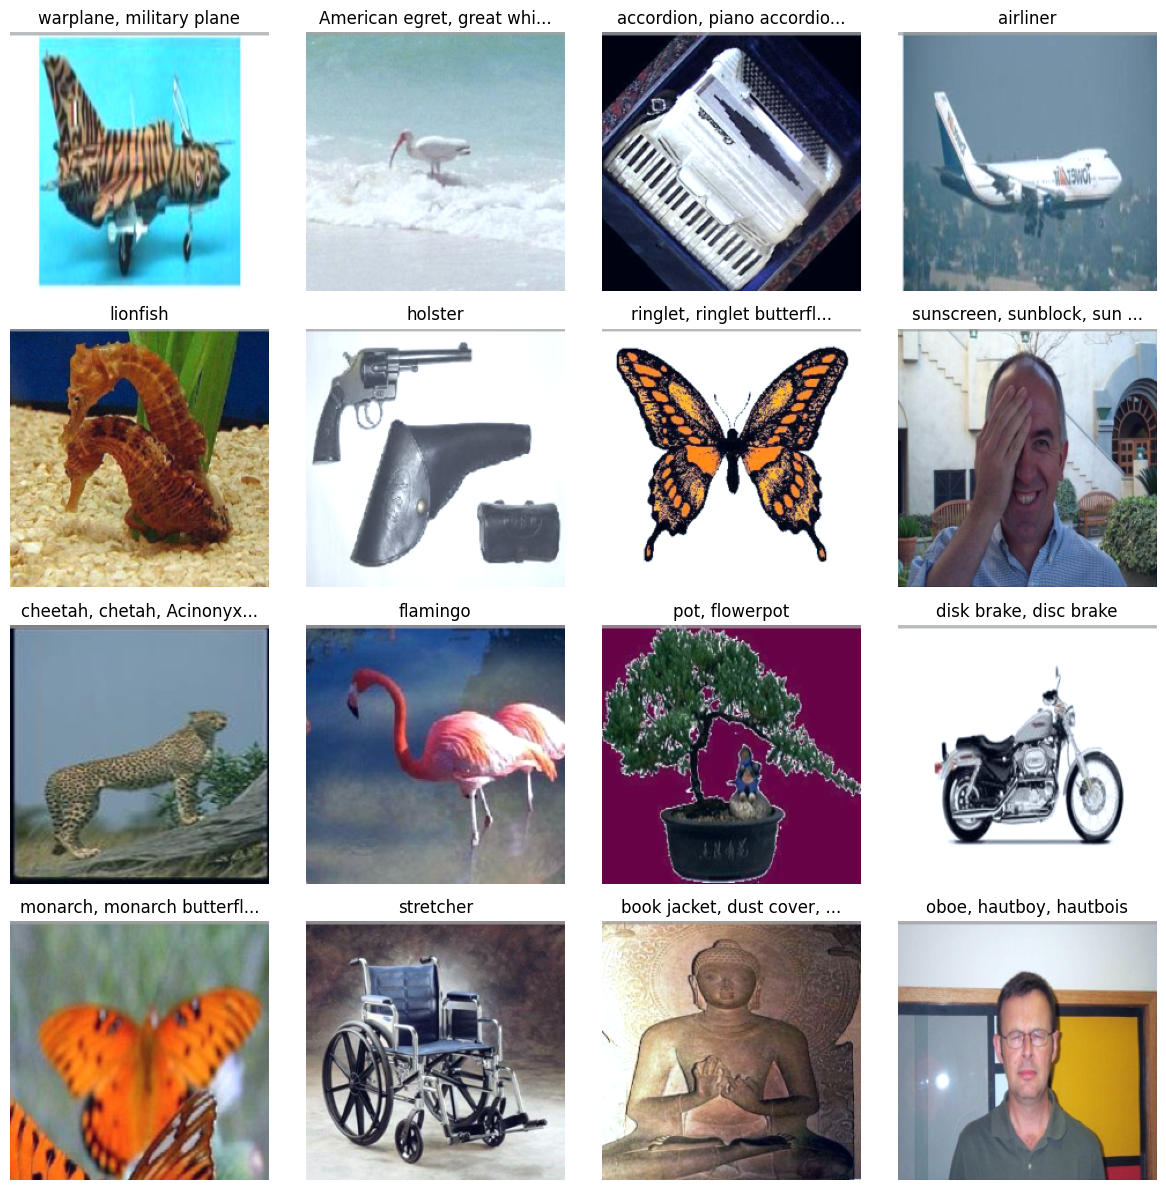

In [7]:
# get the first batch
dataiter = iter(dataloader)
images, _ = next(dataiter)

# define a denorm helper function - this undoes the dataloader normalization so we can see the images better
def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """ Denormalizes an image tensor that was previously normalized. """
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# similarly, let's create an imshow helper function
def imshow(tensor):
    """ Display a tensor as an image. """
    tensor = tensor.permute(1, 2, 0)  # Change from C,H,W to H,W,C
    tensor = denormalize(tensor)  # Denormalize if the tensor was normalized
    tensor = tensor*0.24 + 0.5 # fix the image range, it still wasn't between 0 and 1
    plt.imshow(tensor.clamp(0,1).cpu().numpy()) # plot the image
    plt.axis('off')

# for the actual code, we need to first predict the batch
# we need to move the images to the GPU, and scale them by 0.5 because VIT-L/16 uses a different normalization to the other models
with torch.no_grad(): # this isn't strictly needed since we already disabled autograd, but we should do it for good measure
  output = vit_large_model(images.cuda()*0.5)

# then we can sample the output using argmax (find the class with the highest probability)
# here we are calling output.logits because huggingface returns a struct rather than a tuple
# also, we apply argmax to the last dim (dim=-1) because that corresponds to the classes - the shape is B,C
# and we also need to move the ids to the CPU from the GPU
ids = output.logits.argmax(dim=-1).cpu()

# next we will go through all of the ids and convert them into human readable labels
# huggingface has the .config.id2label map, which helps.
# notice that we are calling id.item() to get the raw contents of the ids tensor
labels = []
for id in ids:
  labels += [vit_large_model.config.id2label[id.item()]]

# finally, let's plot the first 4 images
max_label_len = 25
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
for i in range(4):
    for j in range(4):
        idx = i*4 + j
        plt.sca(axes[i, j])
        imshow(images[idx])
        # we need to trim the labels because they sometimes are too long
        if len(labels[idx]) > max_label_len:
          trimmed_label = labels[idx][:max_label_len] + '...'
        else:
          trimmed_label = labels[idx]
        axes[i,j].set_title(trimmed_label)
plt.tight_layout()
plt.show()

**Question 1**

Given the above classifications, how well do you think the model does?
Can you observe any limitations? If so, do you think that's related to the model size and complexity, or is it more likely related to the training set?

For more information, the class list can be found here: https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/

Please answer below:

The model does just "okay" at identifying each of the objects. The main limitation that I see is with identifying people. This could be due to the training set not having enough images of people in different scenairos to train the AI on.

Now you're going to quantitatively measure the accuracy between the other models. The first thing you need to do is clear the GPU cache, to prevent an out-of-memory error. To undestand this, let's look at the current GPU memory utilization.

In [8]:
# run nvidia-smi to view the memory usage. Notice the ! before the command, this sends the command to the shell rather than python
!nvidia-smi

Mon Oct  6 02:43:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   64C    P0             29W /   70W |    1950MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [9]:
# now you will manually invoke the python garbage collector using gc.collect()
gc.collect()
# and empty the GPU tensor cache - tensors that are no longer needed (activations essentially)
torch.cuda.empty_cache()

In [10]:
# run nvidia-smi again
!nvidia-smi

Mon Oct  6 02:43:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   64C    P0             29W /   70W |    1714MiB /  15360MiB |      5%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

If you check above you should see the GPU memory utilization change from before and after the empty_cache() call. Memory management is one of the quirks that must be considered when dealing with accelerators like a GPU. Unlike with a CPU, there is no swap file to page memory in and out of the device. Instead, this must be handled by the user. When too much of the GPU memory is used, the driver will throw an out-of-memory error (commonly referred to as OOM). In this case, the process often ends up in an unrecoverable state and needs to be restarted to fully reset the memory utilization to zero.

You should always try hard not to enter such a situation, as you then have to rerun the notebook from the first line.

**Question 2**

Given the above, why is the GPU memory utilization not zero? Does the current utilization match what you would expect? Please answer below:

Because I called torch.cuda's empty_cache() function I utilized the GPU, the GPU also is most likely running some background functions in its idle state that takes up some memory. The memory usage dropped from 1901 MiB to down to 1715 MiB. This is not a massive change but it is still a difference.

Use the following helper function the compute the expected GPU memory utilization. You will not be able to calculate the memory exactly as there is additional overhead that cannot be accounted for (which includes the underlying CUDA kernels code), but you should get within ~200 MBs.

**Question 3**

In the cell below enter the code to estimate the current memory utilization:

In [11]:
# helper function to get element sizes in bytes
def sizeof_tensor(tensor):
    # Get the size of the data type
    if (tensor.dtype == torch.float32) or (tensor.dtype == torch.float):      # float32 (single precision float)
        bytes_per_element = 4
    elif (tensor.dtype == torch.float16) or (tensor.dtype == torch.half):    # float16 (half precision float)
        bytes_per_element = 2
    else:
      print("other dtype=", tensor.dtype)
    return bytes_per_element

# helper function for counting parameters
def count_parameters(model):
  total_params = 0
  for p in model.parameters():
    total_params += p.numel()
  return total_params

# estimate the current GPU memory utilization
def estimate_memory_utilization(model, dtype=torch.float32, activations=0):
    param_size = sizeof_tensor(torch.zeros(1, dtype=dtype))
    total_params = count_parameters(model)
    params_memory = total_params * param_size / (1024 ** 2)
    activations_memory = activations * param_size / (1024 ** 2)
    return params_memory + activations_memory
estimated_memory = estimate_memory_utilization(vit_large_model)
print(str(estimated_memory) + " MiB" )

1160.9139709472656 MiB


Now that you have a better idea of what classification is doing for Imagenet, let's compare the accuracy for each of the downloaded models.
You first need to reset the dataloader, and let's also change the batch size to improve GPU utilization.

In [12]:
# set a manual seed for determinism
torch.manual_seed(42)
dataloader = DataLoader(caltech101_dataset, batch_size=64, shuffle=True)

Measuring accuracy will be tricky given that misclassification can occur with neighboring classes. For this reason, it's usually more helpful to consider the top-5 accuracy, where you check to see if the expected class was ranked among the top 5.
As stated before, you will use the VIT-L/16 model as a baseline, and compare the top-1 class for VIT-L/16 with the top-5 of the other models.

Because this takes a while, let's only compute the first 10 batches. That should be enough to do some rough analysis. Since you are using a batch of 64, 10 batches are 640 images.

In [13]:
# Dictionary to store results
accuracies = {"ResNet-18": 0, "ResNet-50": 0, "ResNet-152": 0, "MobileNetV2": 0}
total_samples = 0

num_batches = len(dataloader)

t_start = time.time()

with torch.no_grad():
  for i, (inputs, _)in tqdm(enumerate(dataloader), desc="Processing batches", total=num_batches):

        if i > 10:
          break

        # move the inputs to the GPU
        inputs = inputs.to("cuda")

        # Get top prediction from resnet152
        #baseline_preds = resnet152_model(inputs).argmax(dim=1)
        output = vit_large_model(inputs*0.5)
        baseline_preds = output.logits.argmax(-1)

        # ResNet-18 predictions
        logits_resnet18 = resnet18_model(inputs)
        top5_preds_resnet18 = logits_resnet18.topk(5, dim=1).indices
        matches_resnet18 = (baseline_preds.unsqueeze(1) == top5_preds_resnet18).any(dim=1).float().sum().item()

        # ResNet-50 predictions
        logits_resnet50 = resnet50_model(inputs)
        top5_preds_resnet50 = logits_resnet50.topk(5, dim=1).indices
        matches_resnet50 = (baseline_preds.unsqueeze(1) == top5_preds_resnet50).any(dim=1).float().sum().item()

        # ResNet-152 predictions
        logits_resnet152 = resnet152_model(inputs)
        top5_preds_resnet152 = logits_resnet152.topk(5, dim=1).indices
        matches_resnet152 = (baseline_preds.unsqueeze(1) == top5_preds_resnet152).any(dim=1).float().sum().item()

        # MobileNetV2 predictions
        logits_mobilenetv2 = mobilenet_v2_model(inputs)
        top5_preds_mobilenetv2 = logits_mobilenetv2.topk(5, dim=1).indices
        matches_mobilenetv2 = (baseline_preds.unsqueeze(1) == top5_preds_mobilenetv2).any(dim=1).float().sum().item()

        # Update accuracies
        accuracies["ResNet-18"] += matches_resnet18
        accuracies["ResNet-50"] += matches_resnet50
        accuracies["ResNet-152"] += matches_resnet152
        accuracies["MobileNetV2"] += matches_mobilenetv2
        total_samples += inputs.size(0)

print()
print(f"took {time.time()-t_start}s")

# Finalize the accuracies
accuracies["ResNet-18"] /= total_samples
accuracies["ResNet-50"] /= total_samples
accuracies["ResNet-152"] /= total_samples
accuracies["MobileNetV2"] /= total_samples

Processing batches:   8%|▊         | 11/136 [00:34<06:30,  3.13s/it]


took 34.39542627334595s


**Question 4**

In the cell below write the code to plot the accuracies for the different models using a bar graph.

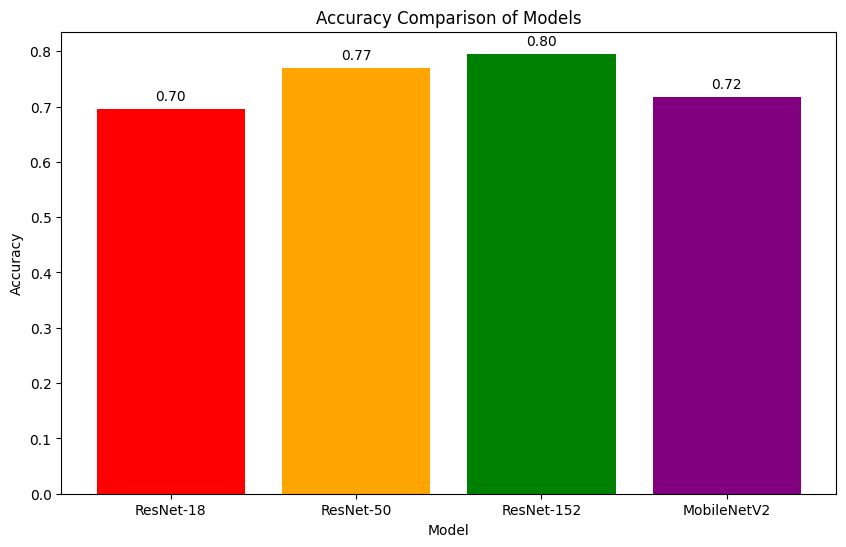

In [14]:
# Define the models and their accuracies
models = list(accuracies.keys())
accuracy_values = list(accuracies.values())

plt.figure(figsize=(10, 6))
plt.bar(models, accuracy_values, color=['red', 'orange', 'green', 'purple'])


plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Models')

for i, value in enumerate(accuracy_values):
    plt.text(i, value + 0.01, f'{value:.2f}', ha='center', va='bottom')
plt.show()

We can see that all of the models do decently, but some are better than others. Why is this and is there a quantifiable trend?

**Question 5**

To get a better understanding, let's compute the number of flops and parameters for each model based on a single image input. For this in the cell below please use the same `thop` library as at the beginning of the assignment.

In [15]:
def profile(model):
  input = torch.randn(1,3,224,224).cuda()

  flops, params = thop.profile(model, inputs=(input, ), verbose=False)
  print(f"model {model.__class__.__name__} has {params:,} params and uses {flops:,} FLOPs")
  return flops, params


model ResNet has 11,689,512.0 params and uses 1,824,033,792.0 FLOPs
model ResNet has 25,557,032.0 params and uses 4,133,742,592.0 FLOPs
model ResNet has 60,192,808.0 params and uses 11,603,945,472.0 FLOPs
model MobileNetV2 has 3,504,872.0 params and uses 327,486,720.0 FLOPs


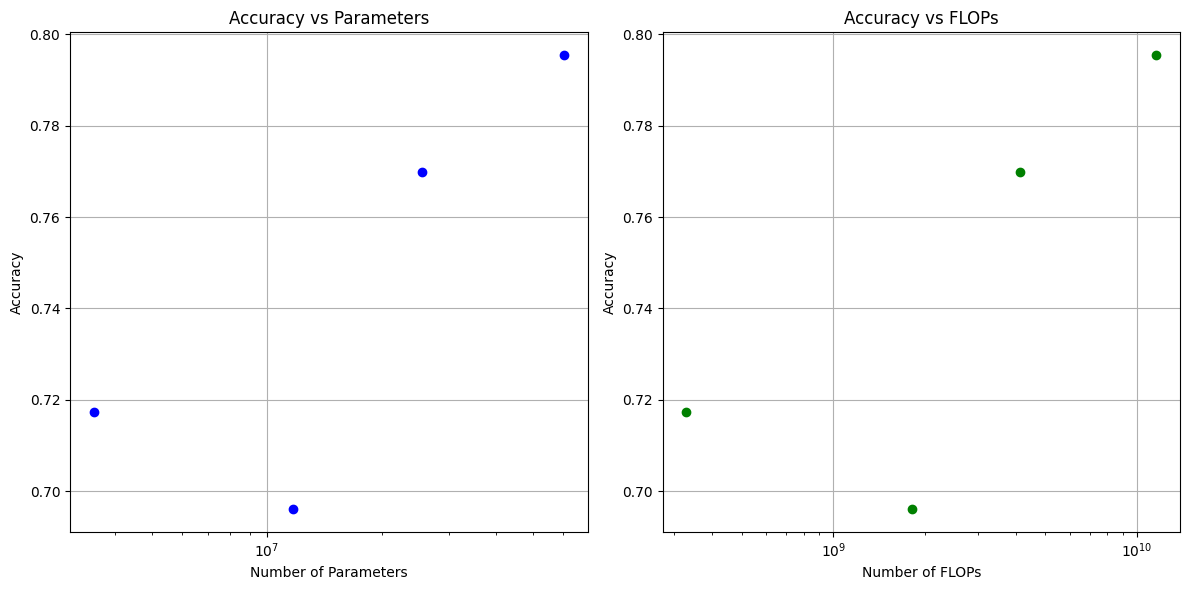

In [16]:
models = {
    "ResNet-18": resnet18_model,
    "ResNet-50": resnet50_model,
    "ResNet-152": resnet152_model,
    "MobileNetV2": mobilenet_v2_model
}
flops_params = {}
# Profiling each model
for name, model in models.items():
    flops, params = profile(model)
    flops_params[name] = {"flops": flops, "params": params}

# Extracting data for plotting
model_names = list(flops_params.keys())
flops_values = [flops_params[name]["flops"] for name in model_names]
params_values = [flops_params[name]["params"] for name in model_names]
accuracy_values = [accuracies[name] for name in model_names]  # Assuming accuracies is defined as before

# Plot Accuracy vs Parameters
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(params_values, accuracy_values, color='blue')
plt.title('Accuracy vs Parameters')
plt.xlabel('Number of Parameters')
plt.ylabel('Accuracy')
plt.xscale('log')  # Log scale for better visualization
plt.grid(True)

# Plot Accuracy vs FLOPs
plt.subplot(1, 2, 2)
plt.scatter(flops_values, accuracy_values, color='green')
plt.title('Accuracy vs FLOPs')
plt.xlabel('Number of FLOPs')
plt.ylabel('Accuracy')
plt.xscale('log')  # Log scale for better visualization
plt.grid(True)

# Show plots
plt.tight_layout()
plt.show()

**Question 6**

Do you notice any trends here? Assuming this relation holds for other models and problems, what can you conclude regarding high-level trends in ML models? Please enter your answer in the cell below:

In general, the more parameters and FLOPs there are, the better the accuracy of the model.

## Performance and Precision

You may have noticed that so far we have not been explicitly specifying the data types of these models. We can do this because torch will default to using float32 (32-bit single-precision).
However, this is not always necessary nor desirable. There are currently a large number of alternative formats (with fewer bits per value), many of which are custom to specific accelerators. We will eventually cover these later in the course, but for now we can consider the second most common type on the GPU: FP16 (half-precision floating-point).

As the name suggests, FP16 only uses 16 bits per value rather than 32. GPUs are specifically designed to handle this datatype and all of the newer ones can execute either one FP32 or two FP16 operations per ALU.

Here's an overview of different precision types: https://moocaholic.medium.com/fp64-fp32-fp16-bfloat16-tf32-and-other-members-of-the-zoo-a1ca7897d407

Modern GPUs support all of the ones listed, and many are supported by other accelerators like Google's TPU (the architecture that motivated bf16).

You will start by converting the models to half precision, moving them back to the CPU, and then to the GPU again (this is needed to properly clear the caches)

In [17]:
# convert the models to half
resnet152_model = resnet152_model.half()
resnet50_model = resnet50_model.half()
resnet18_model = resnet18_model.half()
mobilenet_v2_model = mobilenet_v2_model.half()
vit_large_model = vit_large_model.half()

# move them to the CPU
resnet152_model = resnet152_model.cpu()
resnet50_model = resnet50_model.cpu()
resnet18_model = resnet18_model.cpu()
mobilenet_v2_model = mobilenet_v2_model.cpu()
vit_large_model = vit_large_model.cpu()

# clean up the torch and CUDA state
gc.collect()
torch.cuda.empty_cache()

# move them back to the GPU
resnet152_model = resnet152_model.cuda()
resnet50_model = resnet50_model.cuda()
resnet18_model = resnet18_model.cuda()
mobilenet_v2_model = mobilenet_v2_model.cuda()
vit_large_model = vit_large_model.cuda()

In [18]:
# run nvidia-smi again
!nvidia-smi

Mon Oct  6 02:44:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   76C    P0             33W /   70W |     934MiB /  15360MiB |     27%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**Question 7**

Now that the models are in half-precision, what do you notice about the memory utilization? Is the utilization what you would expect from your previous expected calculation given the new data types? Please answer below:

It appears that there is a significant decrease in memory usage when switching to half-precision. The utilization is expected, it is about half of what it was originally.

Let's see if inference is any faster now.
First reset the data-loader like before.

In [19]:
# set a manual seed for determinism
torch.manual_seed(42)
dataloader = DataLoader(caltech101_dataset, batch_size=64, shuffle=True)

And you can re-run the inference code. Notice that you also need to convert the inptus to .half()

In [20]:
# Dictionary to store results
accuracies = {"ResNet-18": 0, "ResNet-50": 0, "ResNet-152": 0, "MobileNetV2": 0}
total_samples = 0

num_batches = len(dataloader)

t_start = time.time()

with torch.no_grad():
  for i, (inputs, _)in tqdm(enumerate(dataloader), desc="Processing batches", total=num_batches):

        if i > 10:
          break

        # move the inputs to the GPU
        inputs = inputs.to("cuda").half()

        # Get top prediction from resnet152
        #baseline_preds = resnet152_model(inputs).argmax(dim=1)
        output = vit_large_model(inputs*0.5)
        baseline_preds = output.logits.argmax(-1)

        # ResNet-18 predictions
        logits_resnet18 = resnet18_model(inputs)
        top5_preds_resnet18 = logits_resnet18.topk(5, dim=1).indices
        matches_resnet18 = (baseline_preds.unsqueeze(1) == top5_preds_resnet18).any(dim=1).float().sum().item()

        # ResNet-50 predictions
        logits_resnet50 = resnet50_model(inputs)
        top5_preds_resnet50 = logits_resnet50.topk(5, dim=1).indices
        matches_resnet50 = (baseline_preds.unsqueeze(1) == top5_preds_resnet50).any(dim=1).float().sum().item()

        # ResNet-152 predictions
        logits_resnet152 = resnet152_model(inputs)
        top5_preds_resnet152 = logits_resnet152.topk(5, dim=1).indices
        matches_resnet152 = (baseline_preds.unsqueeze(1) == top5_preds_resnet152).any(dim=1).float().sum().item()

        # MobileNetV2 predictions
        logits_mobilenetv2 = mobilenet_v2_model(inputs)
        top5_preds_mobilenetv2 = logits_mobilenetv2.topk(5, dim=1).indices
        matches_mobilenetv2 = (baseline_preds.unsqueeze(1) == top5_preds_mobilenetv2).any(dim=1).float().sum().item()

        # Update accuracies
        accuracies["ResNet-18"] += matches_resnet18
        accuracies["ResNet-50"] += matches_resnet50
        accuracies["ResNet-152"] += matches_resnet152
        accuracies["MobileNetV2"] += matches_mobilenetv2
        total_samples += inputs.size(0)

print()
print(f"took {time.time()-t_start}s")

# Finalize the accuracies
accuracies["ResNet-18"] /= total_samples
accuracies["ResNet-50"] /= total_samples
accuracies["ResNet-152"] /= total_samples
accuracies["MobileNetV2"] /= total_samples

Processing batches:   8%|▊         | 11/136 [00:13<02:32,  1.22s/it]


took 13.438953161239624s


**Question 8**

Did you observe a speedup? Was this result what you expected?
What are the pros and cons to using a lower-precision format? Please answer below:

Yes there was a speed up, it was about three times faster than the original precision format. It is a little faster than I expected. The pros of using this lower precision format is better speed/throughput from the GPU and less memory used by the GPU. This has the negative effect however of worse precision and accuracy by the model.

**Question 9**

Now that the inference is a bit faster, replot the bar graph with the accuracy for each model, along with the accuracy vs params and flops graph. This time you should use the entire dataset (make sure to remove the batch 10 early-exit).

In [21]:
accuracies = {"ResNet-18": 0, "ResNet-50": 0, "ResNet-152": 0, "MobileNetV2": 0}
total_samples = 0

num_batches = len(dataloader)

t_start = time.time()

with torch.no_grad():
    for i, (inputs, _) in tqdm(enumerate(dataloader), desc="Processing batches", total=num_batches):
        inputs = inputs.to("cuda").half()

        output = vit_large_model(inputs * 0.5)
        baseline_preds = output.logits.argmax(-1)

        logits_resnet18 = resnet18_model(inputs)
        top5_preds_resnet18 = logits_resnet18.topk(5, dim=1).indices
        matches_resnet18 = (baseline_preds.unsqueeze(1) == top5_preds_resnet18).any(dim=1).float().sum().item()

        logits_resnet50 = resnet50_model(inputs)
        top5_preds_resnet50 = logits_resnet50.topk(5, dim=1).indices
        matches_resnet50 = (baseline_preds.unsqueeze(1) == top5_preds_resnet50).any(dim=1).float().sum().item()

        logits_resnet152 = resnet152_model(inputs)
        top5_preds_resnet152 = logits_resnet152.topk(5, dim=1).indices
        matches_resnet152 = (baseline_preds.unsqueeze(1) == top5_preds_resnet152).any(dim=1).float().sum().item()

        logits_mobilenetv2 = mobilenet_v2_model(inputs)
        top5_preds_mobilenetv2 = logits_mobilenetv2.topk(5, dim=1).indices
        matches_mobilenetv2 = (baseline_preds.unsqueeze(1) == top5_preds_mobilenetv2).any(dim=1).float().sum().item()

        accuracies["ResNet-18"] += matches_resnet18
        accuracies["ResNet-50"] += matches_resnet50
        accuracies["ResNet-152"] += matches_resnet152
        accuracies["MobileNetV2"] += matches_mobilenetv2
        total_samples += inputs.size(0)

print()
print(f"took {time.time() - t_start}s")
accuracies["ResNet-18"] /= total_samples
accuracies["ResNet-50"] /= total_samples
accuracies["ResNet-152"] /= total_samples
accuracies["MobileNetV2"] /= total_samples


for model, accuracy in accuracies.items():
    print(f"{model} accuracy: {accuracy:.4f}")

Processing batches: 100%|██████████| 136/136 [02:15<00:00,  1.01it/s]


took 135.1503279209137s
ResNet-18 accuracy: 0.6851
ResNet-50 accuracy: 0.7578
ResNet-152 accuracy: 0.7929
MobileNetV2 accuracy: 0.6979


In [22]:
def profile(model):
    input = torch.randn(1, 3, 224, 224).cuda().half()
    flops, params = thop.profile(model, inputs=(input,), verbose=False)

    return flops, params

model_flops_params = {}
for model in [resnet18_model, resnet50_model, resnet152_model, mobilenet_v2_model]:
    flops, params = profile(model)
    model_flops_params[model.__class__.__name__] = (flops, params)

for model_name, (flops, params) in model_flops_params.items():
    print(f"{model_name}: {params:,} parameters, {flops:,} FLOPs")



ResNet: 60,192,808.0 parameters, 11,603,945,472.0 FLOPs
MobileNetV2: 3,504,872.0 parameters, 327,486,720.0 FLOPs


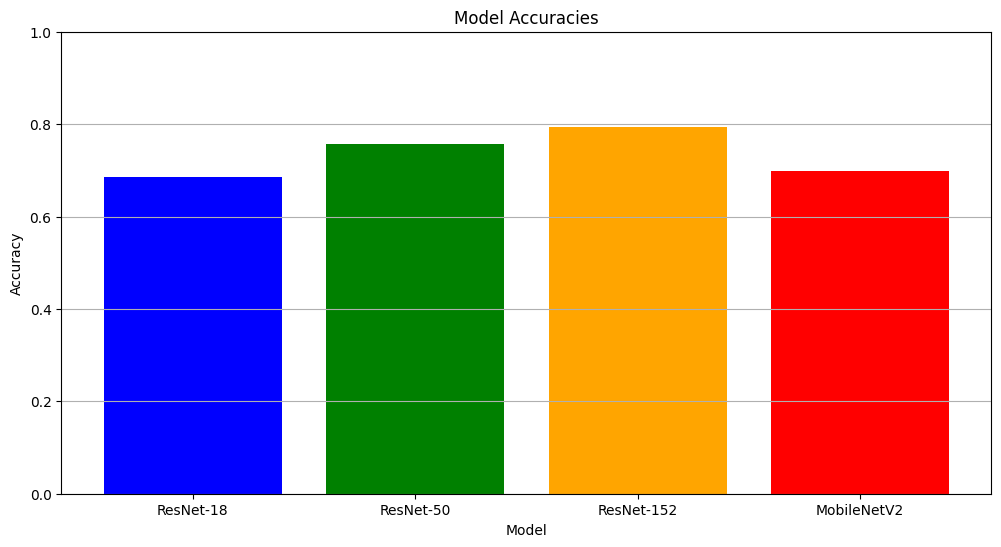

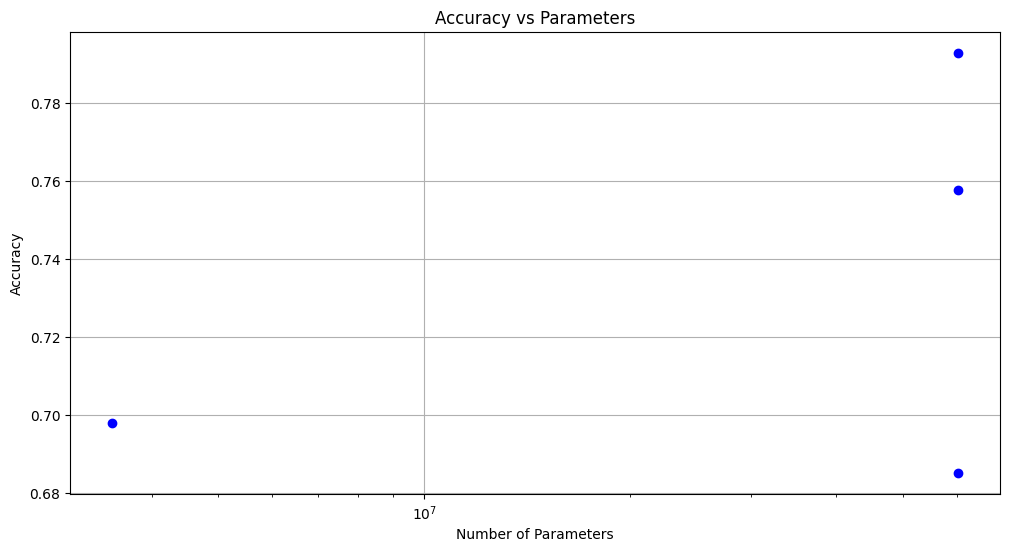

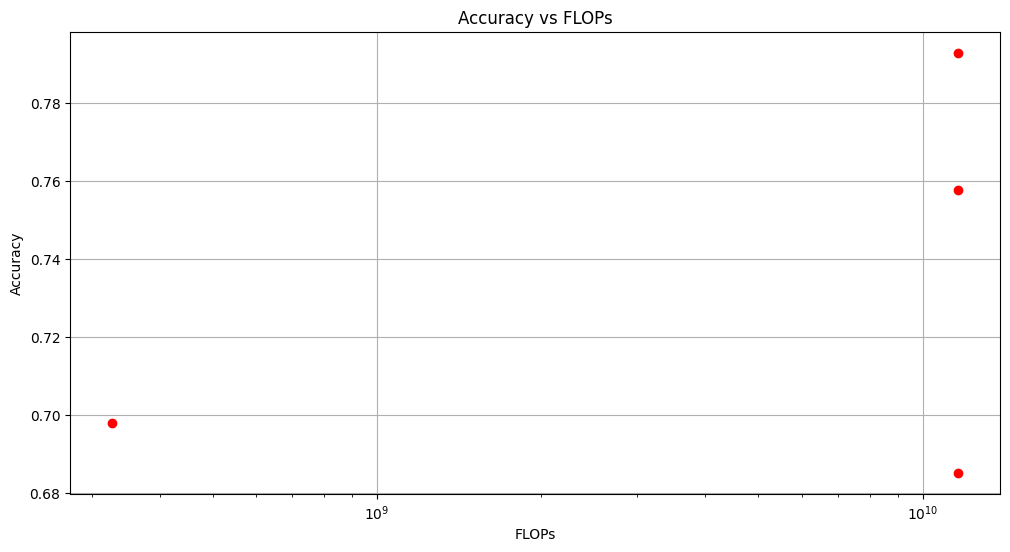

In [23]:

model_flops_params_cleaned = {
    'ResNet-18': model_flops_params['ResNet'],
    'ResNet-50': model_flops_params['ResNet'],
    'ResNet-152': model_flops_params['ResNet'],
    'MobileNetV2': model_flops_params['MobileNetV2']
}

plt.figure(figsize=(12, 6))
plt.bar(model_names, [accuracies[name] for name in model_names], color=['blue', 'green', 'orange', 'red'])
plt.title('Model Accuracies')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()
plt.figure(figsize=(12, 6))
plt.scatter(
    [model_flops_params_cleaned[name][1] for name in model_names],
    [accuracies[name] for name in model_names],
    color='blue'
)
plt.title('Accuracy vs Parameters')
plt.xlabel('Number of Parameters')
plt.ylabel('Accuracy')
plt.xscale('log')
plt.grid(True)
plt.show()
plt.figure(figsize=(12, 6))
plt.scatter(
    [model_flops_params_cleaned[name][0] for name in model_names],
    [accuracies[name] for name in model_names],
    color='red'
)
plt.title('Accuracy vs FLOPs')
plt.xlabel('FLOPs')
plt.ylabel('Accuracy')
plt.xscale('log')
plt.grid(True)
plt.show()


**Question 10**

Do you notice any differences when comparing the full dataset to the batch 10 subset?

it takes much more time to process the full dataset compared to the 10 batch and the accuracy is lower across all models when processing the full dataset. The Resnet networks are also more accurate than the MobileNetV2 on the full data set which is different than the result seen on the batch 10 subset.